# AJ_0075

Here, the aim is to load in bam files and peak calling files into DiffBind and retrieve the raw read counts.  
These counts then can be processed either in DESeq2 like regular expression data - to generate heatmaps, PCAs etc.  
Or can be, as done here, manually processed with a focus on allelic analysis of the chrX.

**Run with conda env: R_ATAC_seq**

In [1]:
library(readr)
library(DiffBind)
library(DESeq2)
library(dplyr)
library(tidyr)
library(ggplot2)
library(viridis)
library(ggridges)
library(readxl)
library(stringr)

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors

Atta

In [2]:
setwd("/staging/leuven/stg_00041/Adrian/AJ_0075_XCU_SONG_DATA/ATAC_seq/")

Create a metadata table which includes absolute paths to bam files (filtered and no dup) and peak calling files

In [3]:
SampleID <- c("CM1_genome1","CM1_genome2","CM2_genome1","CM2_genome2","CM3_genome1","CM3_genome2","CM7_genome1","CM7_genome2")
cell_type <- c("CM1","CM1","CM2","CM2","CM3","CM3","CM7","CM7")
Tissue <- rep("ESC",8)
Factor <- rep(c("XX","XY"), each = 4)
Condition <- rep(c("genome1","genome"), 4)
Treatment <- rep("WT",8)
Replicate <- rep("first",8)
Peaks <- list.files("MACS2",'*.gz', full.names = T)
bamReads <- list.files("SNPSPLIT",'*.bam', full.names = T)
PeakCaller <- rep("macs", 8)
PeakFormat <- rep("bed",8)

In [4]:
samples <- data.frame(SampleID, Tissue,Factor,Condition,Treatment, Replicate, Peaks, bamReads, PeakCaller, PeakFormat)

In [5]:
ATAC_Allele_DBA <- dba(sampleSheet = samples)
ATAC_Allele_DBA

CM1_genome1 ESC XX genome1 WT 1 macs
CM1_genome2 ESC XX genome WT 1 macs
CM2_genome1 ESC XX genome1 WT 1 macs
CM2_genome2 ESC XX genome WT 1 macs
CM3_genome1 ESC XY genome1 WT 1 macs
CM3_genome2 ESC XY genome WT 1 macs
CM7_genome1 ESC XY genome1 WT 1 macs
CM7_genome2 ESC XY genome WT 1 macs


8 Samples, 408110 sites in matrix (1033458 total):
           ID Tissue Factor Condition Treatment Replicate Caller Intervals
1 CM1_genome1    ESC     XX   genome1        WT         1   macs    299987
2 CM1_genome2    ESC     XX    genome        WT         1   macs    299980
3 CM2_genome1    ESC     XX   genome1        WT         1   macs    299991
4 CM2_genome2    ESC     XX    genome        WT         1   macs    299980
5 CM3_genome1    ESC     XY   genome1        WT         1   macs    299989
6 CM3_genome2    ESC     XY    genome        WT         1   macs    299978
7 CM7_genome1    ESC     XY   genome1        WT         1   macs    299986
8 CM7_genome2    ESC     XY    genome        WT         1   macs    299981

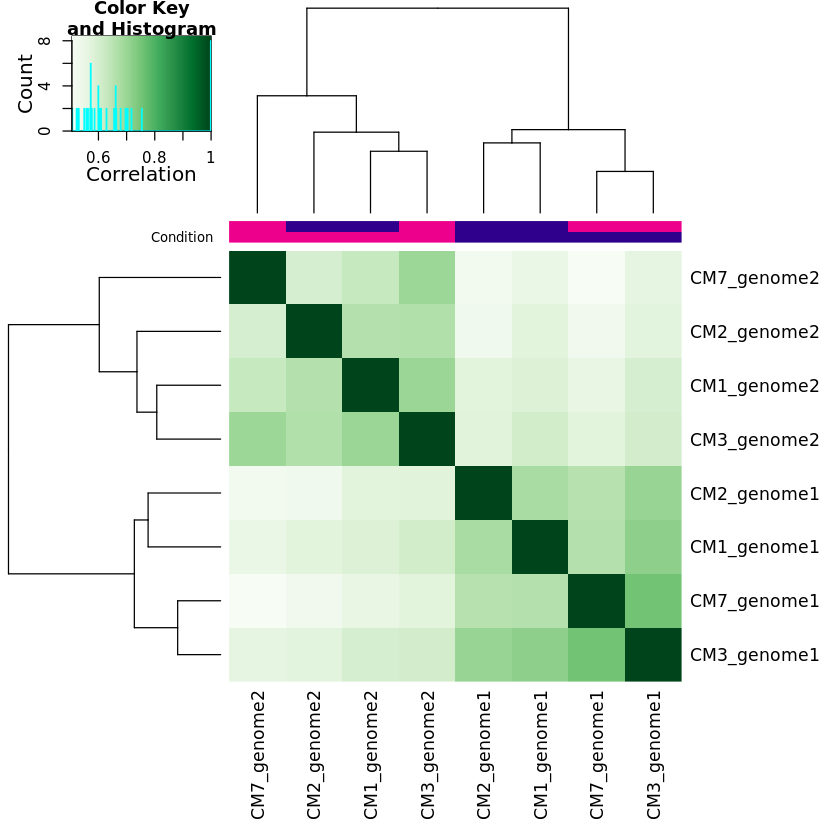

In [6]:
#correlation heatmap can be generated which gives an initial
#clustering of the samples using the cross-correlations of each row of the binding matrix:
plot(ATAC_Allele_DBA)

#### Figure 1: Correlation heatmap, using occupancy (peak caller score) data.
#### It seems that samples cluster as expected. Day 0 very far away from  everything else, and then Day 8 and 9, later to Day 10, and 12 most #### similar with iPSCs. Although Day 12 is still relatively dissimilar to iPSCs.

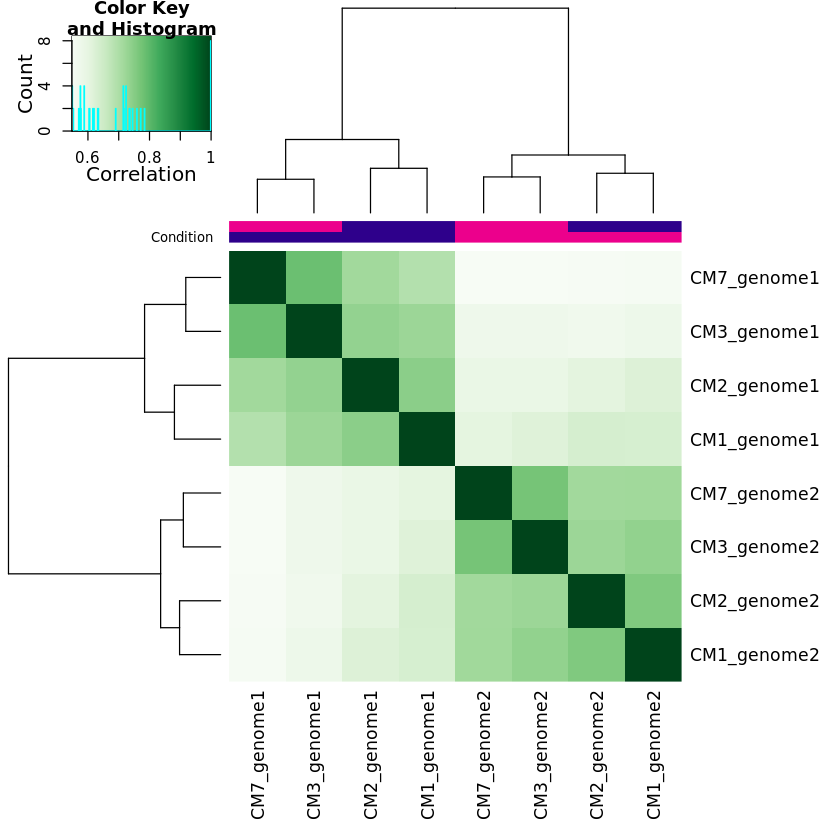

In [7]:
#### The next step is to calculate a binding matrix with scores based on read counts for every
#### sample (affinity scores), rather than confidence scores for only those peaks called in a specific
#### sample (occupancy scores).
ATAC_Allele_DBA_rawCounts <- dba.count(ATAC_Allele_DBA, score = DBA_SCORE_READS) # score = raw read count (without normalization)

plot(ATAC_Allele_DBA_rawCounts)
#### Figure 2: Correlation heatmap, using affinity (read count) data

In [8]:
# Retrieve the peakset with raw read counts

peaks.init.ranges_allele <- dba.peakset(ATAC_Allele_DBA_rawCounts, bRetrieve = TRUE)

#### Process and normalize the raw read counts 

In [9]:
data_raw <- as.data.frame(peaks.init.ranges_allele)
head(data_raw)

seqnames,start,end,width,strand,CM1_genome1,CM1_genome2,CM2_genome1,CM2_genome2,CM3_genome1,CM3_genome2,CM7_genome1,CM7_genome2
chr1,3008518,3008729,212,*,1,1,2,1,2,1,3,2
chr1,3012678,3012785,108,*,1,1,2,1,1,1,1,2
chr1,3027133,3027524,392,*,1,3,5,1,2,3,1,2
chr1,3035676,3035918,243,*,4,1,1,2,7,4,5,1
chr1,3062439,3062745,307,*,11,5,8,6,13,5,7,3
chr1,3062895,3063027,133,*,2,1,5,3,5,3,3,2


In [10]:
data_raw_processed <- data_raw %>% mutate(region_id = as.character(seq(1:nrow((.)))))

genome1 <- data_raw_processed %>%
                    select(region_id,seqnames,start,end, ends_with("genome1")) %>% 
                    gather(cell_type, accessibility_genome1, -region_id, -seqnames,-start,-end)

In [11]:
genome1$cell_type <- str_replace_all(genome1$cell_type, '_genome1', '')

In [12]:
genome2 <- data_raw_processed %>%
                    select(region_id, ends_with("genome2")) %>% 
                    gather(cell_type, accessibility_genome2, -region_id) 

In [13]:
genome2$cell_type <- str_replace_all(genome2$cell_type, '_genome2', '')

In [14]:
data_raw_processed <- left_join(genome1, genome2, by = c("cell_type","region_id"))

In [15]:
data_norm <- data_raw_processed %>%
                mutate(sumReads = accessibility_genome1 + accessibility_genome2) 

In [16]:
data_norm <- data_norm %>%
                group_by(cell_type) %>%
                summarize(total_reads_per_sample = sum(sumReads)) %>%
                right_join(data_norm)

Joining, by = "cell_type"


In [17]:
data_norm <- data_norm %>% 
                mutate(acc_gen1_norm = log1p((accessibility_genome1/total_reads_per_sample)*100000),
                      acc_gen2_norm = log1p((accessibility_genome2/total_reads_per_sample)*100000),
                      sumReads_norm = log1p((sumReads/total_reads_per_sample)*100000))

#### Such prepared and normalized data can be used for downstream analyses.
** Here we focus on the chrX and allelic ratios**

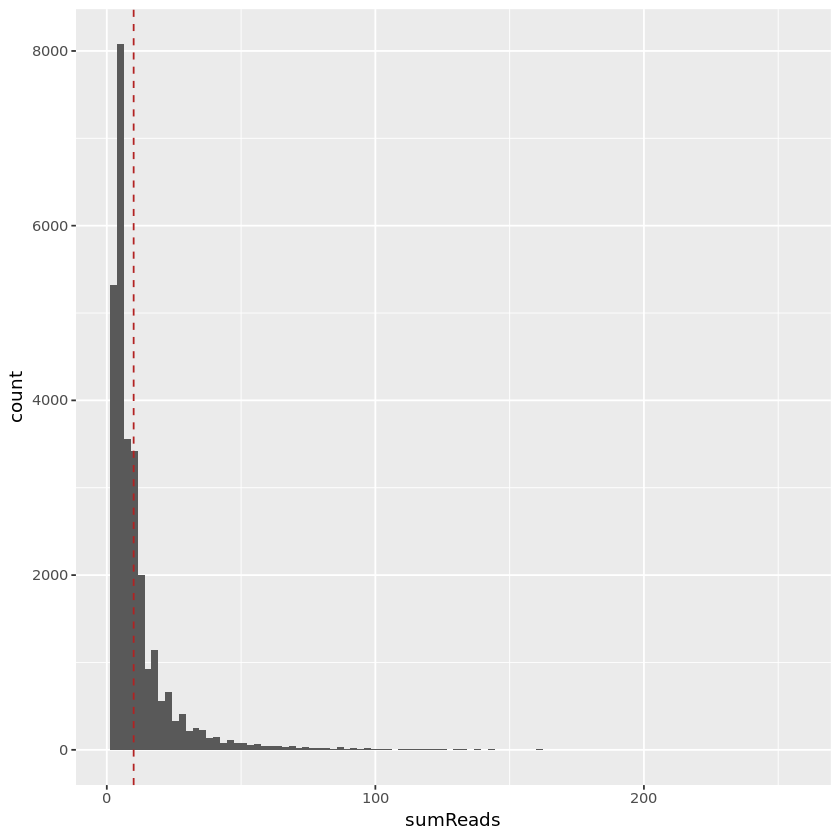

In [18]:
data_norm %>%
    filter(seqnames == "chrX") %>%
    #filter(sumReads < 100) %>%
        ggplot(aes(sumReads)) +
        geom_histogram(bins = 100) +
        geom_vline(xintercept = 10, linetype = "dashed", color = "firebrick")

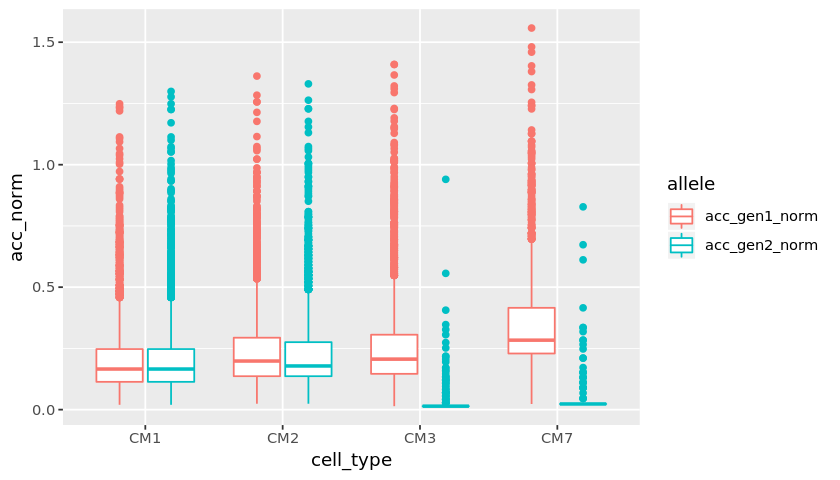

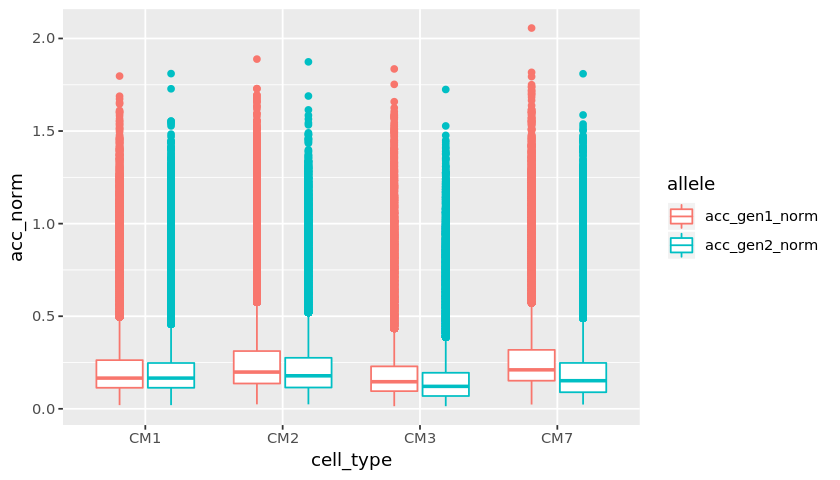

In [19]:
options(repr.plot.height = 4)

data_norm %>% 
    filter(seqnames == "chrX") %>%
    filter(sumReads >= 10) %>%
    select(cell_type, acc_gen1_norm, acc_gen2_norm) %>%
    gather(allele, acc_norm, -cell_type) %>%
        ggplot(aes(cell_type, acc_norm, color = allele)) +
            geom_boxplot()

data_norm %>% 
    filter(!seqnames %in% c("chrX","chrY")) %>%
    filter(sumReads >= 10) %>%
    select(cell_type, acc_gen1_norm, acc_gen2_norm) %>%
    gather(allele, acc_norm, -cell_type) %>%
        ggplot(aes(cell_type, acc_norm, color = allele)) +
            geom_boxplot()

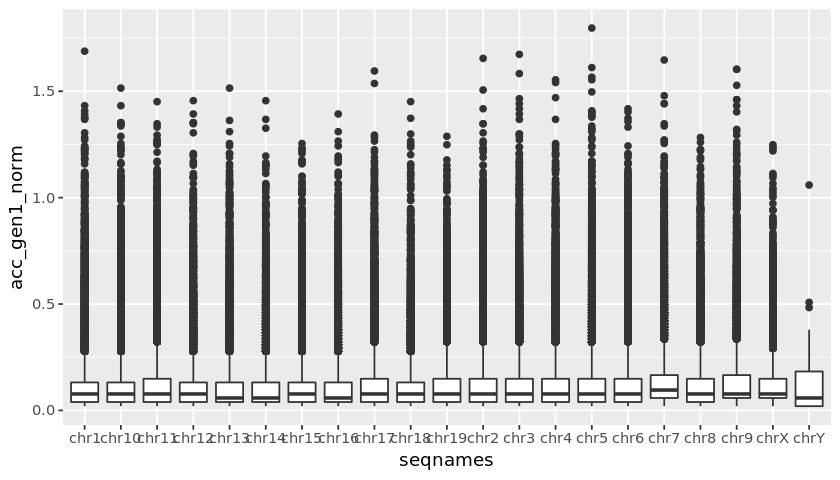

In [20]:
data_norm %>%
    filter(cell_type == "CM1") %>%
    filter(sumReads > 2) %>%
        ggplot(aes(seqnames, acc_gen1_norm)) +
        geom_boxplot()

In [24]:
data_norm %>% write.csv("AJ_0075_ATAC_XX_XY_allelic_data_norm.csv")

#### Calculate X/A ratio

In [21]:
data_filt <- data_norm %>% filter(sumReads >= 10)

auto <- data_filt %>%
            filter(!seqnames %in% c("chrX","chrY")) %>%
            group_by(cell_type) %>%
            summarize(mean_auto_genome1 = mean(acc_gen1_norm),
                      mean_auto_genome2 = mean(acc_gen2_norm),
                     median_auto_genome1 = median(acc_gen1_norm),
                     median_auto_genome2 = median(acc_gen2_norm))

X <- data_filt %>%
            filter(seqnames == "chrX") %>%
            group_by(cell_type) %>%
            summarize(mean_X_genome1 = mean(acc_gen1_norm),
                      mean_X_genome2 = mean(acc_gen2_norm),
                     median_X_genome1 = median(acc_gen1_norm),
                     median_X_genome2 = median(acc_gen2_norm))

ratio_data <- auto %>% left_join(X, by = "cell_type")

ratio_data <- ratio_data %>%
                mutate(ratio_median_genome1 = median_X_genome1/median_auto_genome1,
                       ratio_median_genome2 = median_X_genome2/median_auto_genome2,
                       ratio_mean_genome1 = mean_X_genome1/mean_auto_genome1,
                       ratio_mean_genome2 = mean_X_genome2/mean_auto_genome2)

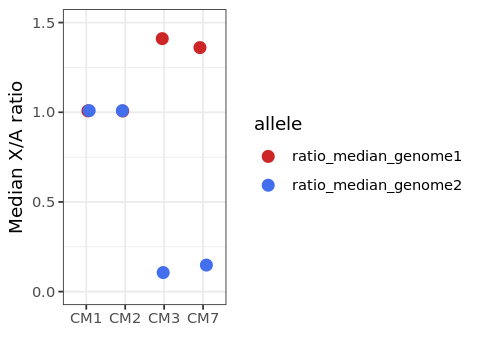

In [22]:
options(repr.plot.height = 3, repr.plot.width = 4)

X_A_plot <- ratio_data %>% select(cell_type, ratio_median_genome1, ratio_median_genome2) %>%
                gather(allele, ratio, -cell_type) %>%
                    ggplot(aes(cell_type, ratio, color = allele)) +
                        geom_jitter(size = 3, width = .1) +
                        scale_color_manual(values = c("firebrick3","royalblue2"))+
                        ylim(0,1.5)+
                        ylab("Median X/A ratio")+
                        xlab("")+
                    theme_bw()

X_A_plot

In [185]:
pdf("AJ_0075_XA_ratio_ESCs.pdf", height = 3, width = 4)
plot(X_A_plot)
dev.off()

png 
  2

In [184]:
getwd()

[1] "/ddn1/vol1/staging/leuven/stg_00041/Adrian/AJ_0075_XCU_SONG_DATA/ATAC_seq"

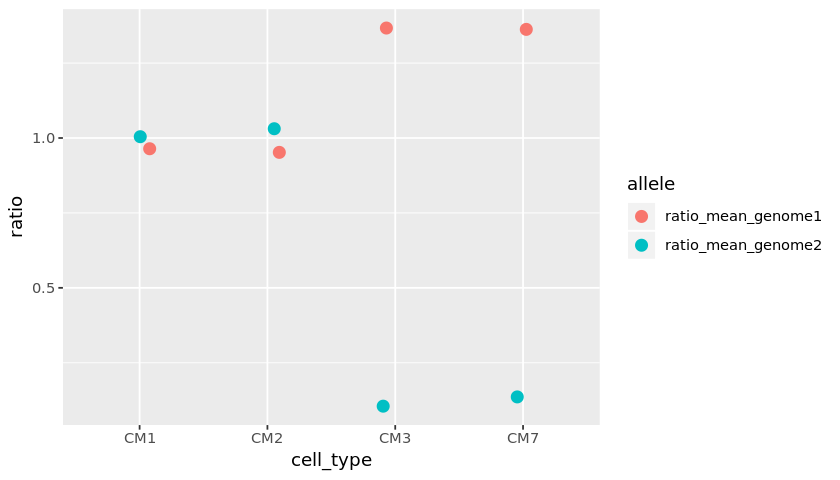

In [170]:
ratio_data %>% select(cell_type, ratio_mean_genome1, ratio_mean_genome2) %>%
    gather(allele, ratio, -cell_type) %>%
        ggplot(aes(cell_type, ratio, color = allele)) +
            geom_jitter(size = 3, width = .1)